# Практическая часть ДЗ 2

# Задача 1. Использование ALS для построения рекомендательной модели (35 баллов)

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [2]:
import zipfile
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('data/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A_{u,m}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{u,m}=1$) и отрицательные (`Rating < 4` &mdash; $A_{u,m} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)).

In [3]:
from scipy.sparse import csr_matrix
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [4]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

### a. (10 баллов) Вычисление ALS-функционала и расстояния между подпространствами

  1. **(5 баллов)** Напомним, что в методе ALS решается задача минимизации функционала $\|A - UV^\top\|_F$ по всем $U$ и $V$ заданного ранга $r$. В самом алгоритме вместо двух матриц $U$ и $V$ естественным образом возникает третья матрица $S \in \mathbb{R}^{r \times r}$, так что текущее приближение выглядит как $USV^\top$. Поэтому первым делом вам нужно будет написать функцию `als_functional` для вычисления оптимизируемого функционала $\|A - USV^\top\|_F$ для заданных $A$, $U$, $S$, $V^\top$ (матрица $S$ не обязана быть диагональной). Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - USV^\top\|_F^2$ через скалярное произведение $(X,Y)_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Имеется в виду, что ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив). Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.
  
  **Замечание**: не используйте циклы по ненулевым элементам разреженной матрицы $A$. Убедитесь, что в ваши формулы входит только умножение на матрицы $A$ или $A^\top$, на которые можно умножать посредством @. 

In [5]:
def als_functional(A, A_norm, U, S, VT):
    return np.sqrt(A_norm**2 -  np.trace(VT @ A.T @ U @ S) + np.trace(U.T @ U @ S @ VT @ VT.T @ S.T) - np.trace(U.T @ A @ VT.T @ S.T))
    """
        Input
            A: sparse 2D array
            A_norm: Frobenius norm of A
            U, S, VT: 2D arrays such that U @ S @ VT approximates A
        Output
            ||A - USVT||_F
    """
    raise NotImplementedError()

  2. **(3 балла)** Ещё одной метрикой сходимости ALS-процесса, помимо стабилизации самого функционала, может служить так называемое расстояние между подпространствами. Расстоянием между подпространствами $L_1 \subset \mathbb{R}^m$ и $L_2 \subset \mathbb{R}^m$ будем называть число $\|P(L_1) - P(L_2)\|_2$, где $P(L_i)$ &mdash; ортопроектор на $L_i$. Опишите алгоритм вычисления расстояния между двумя подпространствами $\mathrm{Im}(U_1)$ и $\mathrm{Im}(U_2)$ для заданных матриц $U_1, U_2 \in \mathbb{R}^{m \times r}$ с ортонормированными столбцами (т.е. $U_i^T U_i = I$). Алгоритм должен иметь сложность $O(mr^2)$. **Подсказка.** Воспользуйтесь фактом, что ортопроекторы являются матрицами малого ранга $r$, и техникой малоранговой арифметики, описанной на соответствующих лекции и семинаре.

Поскольку столбцы $U_i$ ортонормированны, $U_i$ имеет полный ранг, значит $P(U_i) = U_i(U_iU_i^T)^{-1}U_i^T = U_iU_i^T$. Тогда вторая норма это $\|P(U_1) - P(U_2)\|_2$ = $\|U_1U_1^T - U_2U_2^T\|_2$

Заметим, что $U_iU_i^t$ это на самом деле скелетное разложение,то есть можем записать как $U_1U_1^T - U_2U_2^T = [U_1(-U_2)][U_1U_2]^T$ - это будет скелетное разложение для $U_1U_1^T - U_2U_2^T$, обозначим как $UV^T$.

Теперь пусть $U = Q_1R_1, V = Q_2R_2$, тогда $UV^T = Q_1R_1R_2^TQ_2^T = Q_1RQ_2^T$, можем посчитать SVD разложение у R (это займёт O($r^3$)), и возьмём старшее сингулярное. 

**YOUR WORDS GO HERE**

  3. **(2 балла)** Напишите функцию `dist_between_subspaces`, принимающую на вход матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ с ортонормированными столбцами, и возвращающую расстояние между $\mathrm{Im}(U_1)$ и $\mathrm{Im}(U_2)$. Сложность алгоритма должна быть $O(mr^2)$.

In [6]:
def dist_between_subspaces(U1, U2):
    U = np.hstack((U1, -1*U2))
    V = np.hstack((U1, U2))
    Ru = np.linalg.qr(U, mode='r')
    Rv = np.linalg.qr(V, mode='r')
    a, S, b = np.linalg.svd(Ru @ Rv.T, full_matrices=False)
    return S[0]
    
    """
        Input
            U1, U2: matrices with orthonormal columns
        Output
            Distance between Im(U1) and Im(U2)
    """
    raise NotImplementedError()

### b. (12 баллов) Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции). При указании `debug=True` печатайте номер текущей итерации и последнее расстояние между подпространствами, а также любую дополнительную интересную вам информацию. Вам будет необходимо вернуть три матрицы $U$, $S$, $V^\top$, а также список расстояний между $\mathrm{Im}(U_0)$ и $\mathrm{Im}(U_1)$, $...$, $\mathrm{Im}(U_{k-1})$ и $\mathrm{Im}(U_k)$. Матрицы $S$ не обязана быть диагональной.

In [7]:
from scipy.sparse.linalg import norm as sparse_norm

def ALS(A, rank, tolerance=1e-2, debug=False):
    m, n = A.shape
    it = 1
    U_i, _ = np.linalg.qr(np.random.rand(m, rank))
    V_i, _ = np.linalg.qr(np.random.rand(n, rank))
    S = np.eye(rank)
    dist_list = []
    while(True):
        U_ = A @ V_i
        Q_1, R_1 = np.linalg.qr(U_)
        dist_list.append(dist_between_subspaces(U_i, Q_1))
        V_ = A.T @ Q_1
        Q_2, R_2 = np.linalg.qr(V_)
        U_i = Q_1
        V_i = Q_2
        S = R_2.T
        if (debug):
            print("Итерация: {0}, Последнее расстояние: {1}".format(it, dist_list[-1]))
            print("Приближаем с точностью {0}".format(als_functional(A, sparse_norm(A), U_i, S, V_i.T)))
        it += 1
        if (dist_list[-1] <= tolerance):
            return U_i, S, V_i.T, dist_list
    print("END???")
           
        
        
        
    """
        Input
            A: 2D m x n numpy array
            rank: required rank of the approximation
            tolerance: stop when this distance between Im(U_k) and Im(U_{k+1}) is reached
            debug: print debug information on each iteration
            
        Output
            U: m x rank numpy array with orthogonal columns
            S: rank x rank numpy array
            VT: rank x n numpy array with orthogonal rows
            dists: list of distances between Im(U_k) and Im(U_{k+1})
    """
    #raise NotImplementedError()

Запустим метод на матрице `A_train` и посмотрим на убывание расстояния между соседними подпространствами от номера итерации.

Итерация: 1, Последнее расстояние: 0.999999552319308
Приближаем с точностью 1783.647412426301
Итерация: 2, Последнее расстояние: 0.8665695890571203
Приближаем с точностью 1663.2102405337578
Итерация: 3, Последнее расстояние: 0.5270957495310965
Приближаем с точностью 1647.519991441131
Итерация: 4, Последнее расстояние: 0.35478101715778604
Приближаем с точностью 1642.8647232812511
Итерация: 5, Последнее расстояние: 0.25336618271204936
Приближаем с точностью 1640.9968126334495
Итерация: 6, Последнее расстояние: 0.19459687468629727
Приближаем с точностью 1640.1258008241198
Итерация: 7, Последнее расстояние: 0.15128661171843213
Приближаем с точностью 1639.6737068438238
Итерация: 8, Последнее расстояние: 0.1182846404542039
Приближаем с точностью 1639.4173518932273
Итерация: 9, Последнее расстояние: 0.09647388282492088
Приближаем с точностью 1639.260252506638


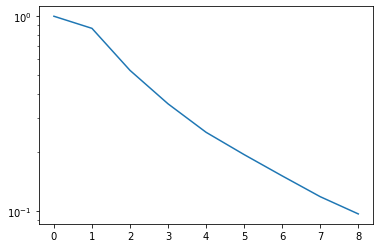

In [8]:
rank = 30
U_als, S_als, VT_als, dist_als = ALS(A_train, rank, 0.1, debug=True)
plt.plot(dist_als)
_ = plt.semilogy()

### c. (3 балла) Сравнение с рандомизированным SVD и разреженным SVD

Примените рандомизированное SVD из sklearn, а также разреженное SVD из scipy (используйте тот же ранг 30, что и для ALS). Сравните все три результата по значению функционала.

In [9]:
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

A_norm = sparse_norm(A_train)
U_rand, S_rand, V_rand = randomized_svd(A_train, 30)
U_sparse, S_sparse, V_sparse = svds(A_train, 30)

print("Ошибка с RandSVD: {0}".format(als_functional(A_train, A_norm, U_rand, np.diag(S_rand),V_rand)))
print("Ошибка с SparseSVD: {0}".format(als_functional(A_train, A_norm, U_sparse,  np.diag(S_sparse), V_sparse)))
print("Ошибка с ALS: {0}".format(als_functional(A_train, A_norm, U_als, S_als, VT_als)))

Ошибка с RandSVD: 1638.815220130178
Ошибка с SparseSVD: 1638.7451222598113
Ошибка с ALS: 1639.260252506638


### d. (10 баллов) Построение рекомендаций
Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V^\top$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `n_recs` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`n_recs` рекомендаций, то есть `n_recs` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `known_ratings` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же.

In [10]:
def recommend(VT, known_ratings, n_recs):
    tmp = VT @ known_ratings.T
    Rec = VT.T @ tmp
    res = np.argsort(-1 * Rec.T)[:, 0:n_recs]
    return res
    """
        Input
            VT: 2D numpy array
            known_rating: sparse batch_size x n_movies array
            n_recs: requested number of recommendations
            
        Output
            recs: batch_size x n_recs array of movies to recommend, with descending predicted rating
    """
    raise NotImplementedError()

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [11]:
from scipy.sparse import find

def evaluate_model(VT, A_test, n_recs, batch_size=500):
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users
            n_recs: requested number of recommendations
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie 
                     in top-n_recs recommendations (or n_recs if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(VT, A_test[nonempty_users[i:i + batch_size], :], n_recs + 1)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V^\top$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `n_recs`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `n_recs == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [12]:
def get_hit_rates(VT, A_test, n_recs):
    hit_indx = evaluate_model(VT, A_test, max(n_recs))
    res = []
    for n_rec in n_recs:
        hit_rate = 0.
        for j in range(len(hit_indx)):
            if hit_indx[j] < n_rec:
                hit_rate += 1
        hit_rate /= len(hit_indx)
        res.append(hit_rate)
    return res
    
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users 
            n_recs: list of ints: number of top recomendations to evaluate hit rate for
        Output
            hit_rates: list of float: hit rate for each element of n_recs
    
    """
    raise NotImplementedError()

Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

In [13]:
acc = get_hit_rates(V_sparse, A_test[0:1000], [10])
acc

[0.10515463917525773]

Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

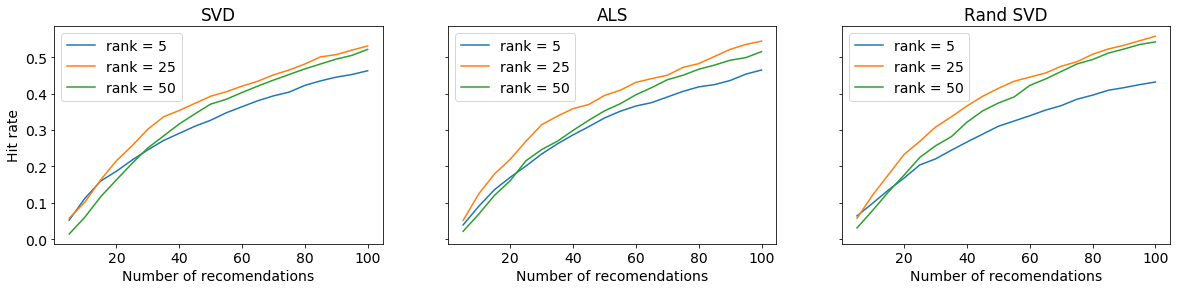

In [14]:
from scipy.sparse.linalg import svds

n_recs = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")
for rank in [5, 25, 50]:
    _, _, VT_svd = svds(A_train, k=rank)
    _, _, VT_als, _ = ALS(A_train, rank)
    _, _, VT_rand = randomized_svd(A_train, rank)
    for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(VT, A_test[:1000,:], n_recs)
        line, = ax.plot(n_recs, hit_rates)
        line.set_label('rank = {}'.format(rank))
        ax.legend()

Какой ранг приближения оказался оптимальным для нашей модели в случае каждого алгоритма?

Лучший ранг - 25.

# Задача 2. Higher-order SVD (25 баллов)

1. (**8 баллов**) Напишите функцию ```tuck2full(G, U, V, W)```, возвращающую полный тензор размера $n_1\times n_2 \times n_3$ по его разложению Таккера. Предусмотрите, чтобы функция работала и в случае, если в матрицах $U,V$ и $W$ строк меньше, чем столбцов. Это понадобится нам в дальнейшем. В этой задаче не разрешается использовать циклы. Вместо них используйте функцию ```np.einsum```.

In [15]:
def tuck2full(G, U, V, W):
    """
        Input
            G: 3D numpy array - Tucker core of size (r1, r2, r3)
            U: 2D numpy array - the first Tucker factor of size (n1, r1)
            V: 2D numpy array - the second Tucker factor of size (n2, r2)
            W: 2D numpy array - the third Tucker factor of size (n3, r3)

        Output
            A: 3D numpy array of the size (n1, n2, n3)
    """
    res = np.einsum('xyz,ix,jy,kz', G, U, V, W, optimize=True)
    return res

Я очень надеюсь, что создатель einsum будет гореть в аду, какая же глина(((((

2. (**14 баллов**) Реализуйте higher-order SVD алгоритм для нахождения разложения Таккера данного трехмерного массива $A\in\mathbb{R}^{n_1\times n_2 \times n_3}$. Алгоритм должен находить малоранговое приближение $A$ с относительной точностью не хуже $\varepsilon$ во Фробениусовой норме. Функция должна вернуть ядро и факторы Таккера у приближающего тензора. В этой задаче не разрешается пользоваться циклами. Для получения ядра Таккера будет удобно воспользоваться функцией ```tuck2full```.

In [16]:
def best_U(A, eps):
    U, S, VT = np.linalg.svd(A, full_matrices=False)
    norm_A = np.linalg.norm(A)
    sum_sing = 0
    rank = 1
    while (np.sqrt(sum_sing + S[-rank]**2) < eps / np.sqrt(3) * norm_A):
        sum_sing += S[-rank]**2
        rank += 1
    return U[:,0:1-rank]

In [17]:
def hosvd(A, eps):
    m, n, l = A.shape
    A_1 = np.reshape(A,(m, n * l), order='f')
    A_2 = np.transpose(A, (1, 0, 2))
    m, n, l = A_2.shape
    A_2 = np.reshape(A_2, (m, n * l), order='f')
    A_3 = np.transpose(A, (2, 0, 1))
    m, n, l = A_3.shape
    A_3 = np.reshape(A_3, (m, n * l), order='f')
    
    U_1 = best_U(A_1, eps)
    U_2 = best_U(A_2, eps)
    U_3 = best_U(A_3, eps)
    G = tuck2full(A, U_1.T, U_2.T, U_3.T)
    return G, U_1, U_2, U_3
    
        
    """
        Input
            A: 3D numpy array
            eps: accuracy of Tucker approximation

        Output
            G: 3D numpy array - the Tucker core
            U: 2D numpy array - the first Tucker factor with orthogonal columns
            V: 2D numpy array - the second Tucker factor with orthogonal columns
            W: 2D numpy array - the third Tucker factor with orthogonal columns
    """

3. (**3 балла**) Примените функцию ```hosvd``` к тензору размера $100 \times 200 \times 300$ с элементами
$$
    a_{ijk} = \frac{1}{i + j + k + 1}, \quad i,j,k=0,1,...
$$
для малорангового приближения с точностью $10^{-6}$. Напечатайте получившиеся ранги и относительную ошибку полученного малорангового приближения (для этого используйте функцию ```tuck2full```).

In [18]:
Tens = np.zeros((100, 200, 300), dtype=float)
for i in range(100):
    for j in range(200):
        for k in range(300):
            Tens[i][j][k] = 1./(i + j + k + 1)

In [19]:
G, U, V, W = hosvd(Tens, 1e-6)

In [20]:
print("Полученные ранги: {0}".format(G.shape))
print("Ошибка: {0}".format(np.linalg.norm(Tens - tuck2full(G, U, V, W)) / np.linalg.norm(Tens)))

Полученные ранги: (10, 11, 11)
Ошибка: 4.843464315252344e-07
